In [33]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
warnings.filterwarnings("ignore", category=FutureWarning)

files = glob.glob('./server_results/use_bp_ablation/*.csv')

# sns.set(style="white")

In [34]:
# Read and concatenate all dataframes
df_list = [pd.read_csv(file) for file in files]
df = pd.concat(df_list, ignore_index=True)
df['dataset'] = df['dataset'].replace('gdc_studies', 'GDC')
df['dataset'] = df['dataset'].replace('musicians', 'Musicians')
df.dataset.unique()

array(['Magellan', 'Musicians', 'OpenData', 'TPC-DI', 'ChEMBL', 'GDC'],
      dtype=object)

In [35]:
def compute_difference(df, metric='mrr'):

    nonbp_bp_pairs = df[df['method'].isin(['MatchMakerNonBP', 'MatchMaker_BP'])]

    # Add a group column to identify consecutive pairs
    nonbp_bp_pairs['group'] = (nonbp_bp_pairs['method'] == 'MatchMakerNonBP').cumsum()

    # Reshape to pair rows for NonBP and BP
    pairs = nonbp_bp_pairs.pivot(index='group', columns='method', values=metric)

    # Calculate the absolute difference
    #pairs['absolute_difference'] = abs(pairs['MatchMaker_BP'] - pairs['MatchMakerNonBP'])
    pairs['difference'] = pairs['MatchMaker_BP'] - pairs['MatchMakerNonBP']

    # Reset index and keep only the absolute differences
    result = pairs[['difference']].reset_index(drop=True)

    return result


In [36]:
# Initialize a list to store data for all datasets
all_mrr = []
all_recall = []

# Iterate over each dataset
for dataset in df['dataset'].unique():
    df_dataset = df[df['dataset'] == dataset]

    # Compute MRR and Recall percentage changes
    mrr_dist = compute_difference(df_dataset)
    recall_dist = compute_difference(
        df_dataset, metric='All_RecallAtSizeofGroundTruth')

    # Append results with dataset information for grouping
    mrr_dist['dataset'] = dataset
    mrr_dist['metric'] = 'MRR'
    all_mrr.append(mrr_dist)

    recall_dist['dataset'] = dataset
    recall_dist['metric'] = 'Recall'
    all_recall.append(recall_dist)

# Combine all datasets
mrr_df = pd.concat(all_mrr, ignore_index=True)
recall_df = pd.concat(all_recall, ignore_index=True)

# Combine MRR and Recall into one DataFrame for grouped boxplot
combined_df = pd.concat([mrr_df, recall_df], ignore_index=True)

In [37]:
def get_stats(df, metric=None):
    stats = combined_df.groupby(['dataset', 'metric'])['difference'].agg(['min', 'max', 'mean', 'median', 'std']).reset_index()
    stats.columns = ['dataset', 'metric', 'min_difference', 'max_difference', 'mean_difference', 'median_difference', 'std_difference']
    

    if metric:
        stats = stats[stats['metric'] == metric]

    stats = stats.round(2)
    stats = stats.sort_values(by='mean_difference', ascending=False)

    return stats

stats = get_stats(combined_df, 'MRR')
print(stats)

      dataset metric  min_difference  max_difference  mean_difference  \
8    OpenData    MRR           -0.50            0.80             0.04   
0      ChEMBL    MRR           -0.50            0.22             0.01   
6   Musicians    MRR            0.00            0.03             0.01   
4    Magellan    MRR            0.00            0.00             0.00   
10     TPC-DI    MRR           -0.19            0.14             0.00   
2         GDC    MRR           -0.06            0.03            -0.01   

    median_difference  std_difference  
8                0.01            0.12  
0                0.00            0.10  
6                0.00            0.01  
4                0.00            0.00  
10               0.00            0.06  
2                0.00            0.03  


In [38]:
stats = get_stats(combined_df, 'Recall')
print(stats)

      dataset  metric  min_difference  max_difference  mean_difference  \
1      ChEMBL  Recall           -0.17            1.00             0.17   
9    OpenData  Recall           -0.07            1.00             0.15   
11     TPC-DI  Recall           -0.33            0.47             0.10   
7   Musicians  Recall            0.00            0.20             0.08   
3         GDC  Recall           -0.12            0.10             0.03   
5    Magellan  Recall            0.00            0.00             0.00   

    median_difference  std_difference  
1                0.15            0.22  
9                0.12            0.17  
11               0.07            0.14  
7                0.06            0.10  
3                0.05            0.06  
5                0.00            0.00  


In [39]:
# # Plot the distribution of MRR and Recall using an `ax` object
# fig, ax = plt.subplots(figsize=(12, 6))

# sns.boxplot(data=combined_df, x='dataset', y='difference', hue='metric', palette='Set2', ax=ax, showfliers=False)

# ax.set_title('Distribution of Percentage Changes for MRR and Recall by Dataset', fontsize=14)
# ax.set_xlabel('Dataset', fontsize=12)
# ax.set_ylabel('Percentage Change', fontsize=12)
# ax.tick_params(axis='x', rotation=45)
# ax.legend(title='Metric', fontsize=14)
# plt.tight_layout()

# # Show the plot
# plt.show()

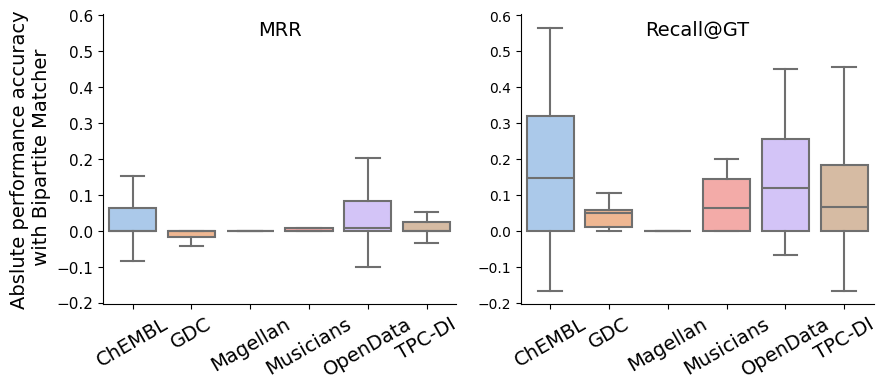

In [ ]:

combined_df = combined_df.sort_values(by='dataset')



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Plot the distribution for MRR in the first axis (ax1)
sns.boxplot(data=combined_df[combined_df['metric'] == 'MRR'], 
            x='dataset', y='difference', palette='pastel', ax=ax1, showfliers=False)
ax1.set_title('MRR', fontsize=14, y=0.9)
ax1.set_xlabel(None)
ax1.set_ylabel('Abslute accuracy difference\n with Bipartite Matcher', fontsize=14)
ax1.tick_params(axis='x', labelsize=14, rotation=30)
ax1.tick_params(axis='y', labelsize=11)


# Plot the distribution for Recall in the second axis (ax2)
sns.boxplot(data=combined_df[combined_df['metric'] == 'Recall'], 
            x='dataset', y='difference', palette='pastel', ax=ax2, showfliers=False)
ax2.set_title('Recall@GT', fontsize=14, y=0.9)
ax2.set_xlabel(None)
ax2.set_ylabel('', fontsize=14)
ax2.tick_params(axis='x', labelsize=14, rotation=30)

ax1.tick_params(axis='y', which='both', labelleft=True)
ax2.tick_params(axis='y', which='both', labelleft=True)

sns.despine()

plt.subplots_adjust(bottom=0.2)

# Save the plot to a file in high resolution
plt.savefig('figures/bp_ablation.pdf', dpi=300)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
